# Redes Neurais Artificiais – Projeto Prático 2.1
## Aprendizado Supervisionado no Neurônio Perceptron
Neste projeto prático, o objetivo é implementar o algoritmo de treinamento mediante Aprendizado Supervisionado do neurônio Perceptron de Rosenblatt aplicado em problemas de classificação.

---

### Equipe (Identificador: 3):

*   Adriana Raffaella Dos Santos Fonseca
*   Ana Flavia de Castro Segadilha da Silva
*   Guilherme Gonçalves Moraes
*   Yago De Oliveira Feitoza



## Bibliotecas

In [30]:
#Importação das bibliotecas
import gdown
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns
import math
from prettytable import PrettyTable
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

## Leitura de Dados

In [31]:
class File:
  """
  [Resumo]

  Classe para manipulação de arquivos de dados armazenados no Google Drive.

  A classe fornece métodos para baixar e carregar arquivos do Drive,
  convertendo-os em dataFrames pandas para uso no treinamento da rede neural.

  Atributos:
  ----------
  X: numpy.ndarray or None
     Array contendo os dados de entrada.
  y_d: numpy.ndarray or None
     Array contendo os valores alvos desejados de y.
  data_name: pd.DataFrame or None.
     DataFrame contendo os dados carregados.
  """

  def __init__(self):
    """Inicializa um objeto File com todos os atributos como None."""
    self.X = None
    self.y_d = None
    self.data_name = None

  def read_data(self, url, file_name, data_name):
    """
      Baixar um arquivo do Google Drive e leitura como DataFrame.

      Realiza o download do arquivo, converte para um array numpy e reformata os dados
      em um Dataframe pandas com colunas nomeadas. Também extrai os dados de entrada (X) e os alvos (y_d).

      Parâmetros:
      -----------
          url (str): URL do arquivo no Drive.
          file_name (str): Nome do arquivo que será salvo localmente.
          data_name (str): Nome de referência para o conjunto de dados.

      Exemplos:
      ------
          >>> arquivo = File()
          >>> arquivo.read_data('https://drive.google.com/uc?export=download&id={id_arquivo}', 'dados.txt', 'dados')
    """
    gdown.download(url, file_name, quiet=False) #Baixa o arquivo ignorando avisos de segunrança

    #Carrega os dados do arquivo binário
    ndarray = np.fromfile(file_name, dtype=np.float64)
    ndarray = ndarray.reshape(-1, 1, 3) #O -1 é para definir automáticamente o tamanho do array
    ndarray_2d = ndarray.reshape(-1, 3) #Redimensiona para 2D

    #Cria o DataFrame com os dados
    self.data_name = pd.DataFrame(ndarray_2d, columns=['Dado 1', 'Dado 2', 'Y desejado'])
    print(f"\n\n{self.data_name.head()}")

    #Extrai os dados de entrada e os alvos
    self.X = self.data_name[['Dado 1', 'Dado 2']].values #Dados da primeira e segunda coluna
    self.y_d = self.data_name[['Y desejado']].values #Última coluna


In [32]:
arquivo = File()

arquivo.read_data('https://drive.google.com/uc?export=download&id=18xVywKIw4WCCDXXAf-G-DflLfA5EQeeM', 'dataAll.txt', "data")

X = arquivo.X
y_d = arquivo.y_d
data = arquivo.data_name

Downloading...
From: https://drive.google.com/uc?export=download&id=18xVywKIw4WCCDXXAf-G-DflLfA5EQeeM
To: /content/dataAll.txt
100%|██████████| 24.0k/24.0k [00:00<00:00, 25.1MB/s]



     Dado 1    Dado 2  Y desejado
0 -363.7884  244.1423         0.0
1  328.7572 -256.7658         1.0
2 -164.9827  613.2164         0.0
3  536.5905  764.9575         0.0
4  314.2297  343.8375         0.0


## Parte I – Resolvendo um Problema Linearmente Separável

###Implementação do Neurônio Perceptron

In [33]:
class Perceptron:
    """
    Classe estruturada para o treinamento do neurnio Perceptron para classificação binária.

    Com as seguintes implementações:
    - Inicializa pesos aleatórios
    - Função de ativação degrau
    - Treinamento do neurônio
    - Métodos para análise de desempenho
    - Visualização dos resultados para um problema linearmente separável

    Atributos:
    ----------
        pesos (numpy.ndarray): Vetor de pesos incluindo o viés. Formato: (n_inputs + 1)
        pesos_iniciais (srt): Armazena os pesos iniciais (para registro)
        taxa_aprendizado (float): Taxa de aprendizado (η) utilizado no treinamento (default: 0.1)
        max_epocas (int): Quantidade de épocas máxima de épocas utilizadas no treinamento (default: 1000)
        epocas (int): Quantidade real de épocas utilizadas no treinamento
        ajuste_pesos (int): Contador de ajustes de pesos realizados até a convergência
        intervalo_pesos (tuple): Intervalo (min, max) para inicialização aleatória de pesos (default: (-0.5, 0.5))
    """

    def __init__(self, n_inputs, taxa_aprendizado=0.1, max_epocas=1000, intervalo_pesos=(-0.5, 0.5)):
        """
        Inicializa um objeto Perceptron com os parâmetros de treinamento.

        Parâmetros:
        ----------
            n_inputs (int): Número de dados de entrada
            taxa_aprendizado (float): Taxa de aprendizado (default: 0.1)
            max_epocas (int): Número máximo de épocas de treinamento (default: 1000)
            intervalo_pesos (tuple): Intervalo (min, max) para inicialização aleatória de pesos (default: (-0.5, 0.5))
        """
        self.pesos = np.random.uniform(intervalo_pesos[0], intervalo_pesos[1], size=n_inputs + 1)
        self.pesos_iniciais = f'[{self.pesos[0]:.3f}, {self.pesos[1]:.3f}, {self.pesos[2]:.3f}]'
        self.taxa_aprendizado = taxa_aprendizado
        self.max_epocas = max_epocas
        self.epocas = 0
        self.ajuste_pesos = 0
        self.intervalo_pesos = (intervalo_pesos[0], intervalo_pesos[1])

    def funcao_ativacao(self, x):
        ''' Define a função degrau (θ=0) '''
        return 1 if x >= 0 else 0

    def previsao(self, x):
        '''Realiza a previsão de y para uma única amostra'''
        xi_vies = np.insert(x, 0, 1) #Adiciona o termo de viés
        return self.funcao_ativacao(np.dot(xi_vies, self.pesos))

    def train(self, X, y, intervalo_pesos):
        """
        Treina o neurônio por meio de ajustes de pesos com base no conjunto de dados fornecidos.

        O treinamento aplica a regra Delta e atinge a condição de parada quando:
        - Todos os dados são classificados corretamente (Convergência)
        - Atinge o número máximo de épocas
        """
        while self.epocas < self.max_epocas:
            erro_flag = False
            for xi, y_d in zip(X, y):
                y_p = self.previsao(xi)
                error = y_d - y_p
                xi_vies = np.insert(xi, 0, 1)
                #Aplicação da Regra Delta
                if error != 0:
                    self.pesos += self.taxa_aprendizado * error * xi_vies
                    self.ajuste_pesos += 1
                    erro_flag = True
            self.epocas += 1
            if not erro_flag: #Ao convergir o treinamento é finalizado
                break

    # Função adicionada para a Parte 2
    def calcular_media(self, ajustes_peso):
        """
        Calcula a média de ajustes de pesos.

        Parâmetros:
        ----------
            ajustes_peso (list): Lista que armazena todas as quantidades de ajuste de pesos

        Retorna:
        ----------
            float: Média dos valores de ajuste de pesos
            """
        return sum(ajustes_peso) / len(ajustes_peso)

    # Função adicionada para a Parte 2
    def calcular_minimo(self, todas_epocas):
        '''Retorna o valor mínimo de épocas das múltiplas execuções.'''
        return min(todas_epocas)

    def calcular_dp(self, ajustes_peso):
        '''Retorna o desvio padrão da quantidade de ajustes de pesos'''
        return float(np.std(ajustes_peso))

    def grafico(self, X, y):
        """
        Plota o gráfico para os resultados de problemas linearmente separáveis.

        Parâmetros:
        ----------
            X (numpy.ndarray): Dados de entrada
            y (numpy.ndarray): Vetor com os valores alvos
            data (pandas.DataFrame): DataFrame contendo os dados originais para plotagem
        """

        # Plotando os dados
        plt.figure(figsize=(6, 6))
        for label in data["Y desejado"].unique():
            subset = data[data["Y desejado"] == label]
            plt.scatter(subset["Dado 1"], subset["Dado 2"], label=f"Classe {int(label)}", alpha=0.7)

        # Cálculo para a linha de decisão
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1 #Calcula os máximos minimos do x, com uma margem de uma unidade para determinar os limites horizontais para a plotagem
        x_vals = np.array([x_min, x_max])
        y_vals = (self.pesos[0] / self.pesos[2]) - (self.pesos[1] / self.pesos[2]) * x_vals

        # Plot da linha de decisão
        plt.plot(x_vals, y_vals, color='black', label='Linha de decisão', linewidth=2)

        # Estilizando o gráfico
        plt.title("Resultados")
        plt.xlabel("Dado 1")
        plt.ylabel("Dado 2")
        plt.legend()
        plt.grid(False)
        plt.show()

###Resultados do Treinamento

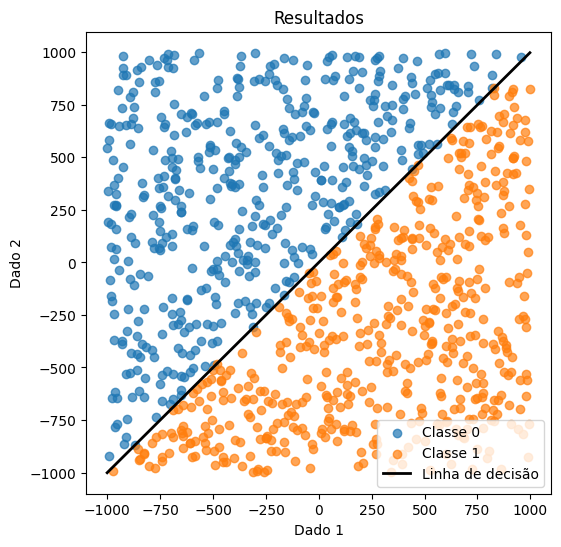

Pesos iniciais : [0.15, -0.22, 0.18]
Quantidade de ajustes no vetor de pesos: 55
Pesos finais após treinamento: [0.65, 323.19, -323.33]
Quantidade de épocas: 4



In [34]:
perceptron = Perceptron(n_inputs=X.shape[1])

perceptron.train(X, y_d, intervalo_pesos=(-0.5, 0.5))
perceptron.grafico(X, y_d)

print(f"Pesos iniciais : {perceptron.pesos_iniciais}")
print(f"Quantidade de ajustes no vetor de pesos: {perceptron.ajuste_pesos}")
print(f"Pesos finais após treinamento: [{perceptron.pesos[0]:.3f}, {perceptron.pesos[1]:.3f}, {perceptron.pesos[2]:.3f}]")
print(f"Quantidade de épocas: {perceptron.epocas}\n")

## Parte II – Experimentação

###Leitura do arquivo data3.txt

In [35]:
arquivo.read_data('https://drive.google.com/uc?export=download&id=1RoXGITcMlWDFydO8Y16Vw1MgPvpl6q75', 'data3.txt', "data3")

X = arquivo.X
y_d = arquivo.y_d
data3 = arquivo.data_name

Downloading...
From: https://drive.google.com/uc?export=download&id=1RoXGITcMlWDFydO8Y16Vw1MgPvpl6q75
To: /content/data3.txt
100%|██████████| 14.4k/14.4k [00:00<00:00, 30.1MB/s]



     Dado 1    Dado 2  Y desejado
0  0.061628 -0.124257         0.0
1 -0.125767 -0.203857         0.0
2  0.036252 -0.126108         0.0
3 -0.003661  0.023619         0.0
4 -0.154962  0.145064         0.0


### Listas de *η* e *I*

In [36]:
taxas_aprendizado = [0.4, 0.1, 0.01] # Possíveis valores para a Taxa de Apendizado
intervalos_pesos = [(-0.5, 0.5), (-100, 100)] # Possíveis valores para intervalo de peso

### Inicialização da Tabela

In [37]:
table = PrettyTable()
table.field_names = ["Taxa de Aprendizado", "Intervalo de Pesos", "Quantidade de Ajustes", "Menor número de épocas para convergência"]

### Testes e resultados

In [38]:
for taxa_aprendizados in taxas_aprendizado:
    for intervalo_peso in intervalos_pesos:

        repeticao = 0

         # Inicializa os vetores para cada repetição
        ajustes_peso = []
        todas_epocas = []

        while repeticao <= 10:

            perceptron = Perceptron(n_inputs=X.shape[1], taxa_aprendizado=taxa_aprendizados, intervalo_pesos=intervalo_peso)
            perceptron.train(X, y_d, intervalo_peso)

            ajustes_peso.append(perceptron.ajuste_pesos)
            todas_epocas.append(perceptron.epocas)

            repeticao += 1

        table.add_row([f'η = {perceptron.taxa_aprendizado}', f'{perceptron.intervalo_pesos}',
                       f'{perceptron.calcular_media(ajustes_peso):.4f} ± {perceptron.calcular_dp(ajustes_peso):.4f}',
                       perceptron.calcular_minimo(todas_epocas)])

print(table)

+---------------------+--------------------+------------------------+------------------------------------------+
| Taxa de Aprendizado | Intervalo de Pesos | Quantidade de Ajustes  | Menor número de épocas para convergência |
+---------------------+--------------------+------------------------+------------------------------------------+
|       η = 0.4       |    (-0.5, 0.5)     |    8.1818 ± 3.0397     |                    3                     |
|       η = 0.4       |    (-100, 100)     |  249.5455 ± 125.1874   |                    5                     |
|       η = 0.1       |    (-0.5, 0.5)     |    11.1818 ± 4.5291    |                    2                     |
|       η = 0.1       |    (-100, 100)     |  1101.1818 ± 731.1754  |                    10                    |
|       η = 0.01      |    (-0.5, 0.5)     |   58.3636 ± 29.1057    |                    5                     |
|       η = 0.01      |    (-100, 100)     | 12325.3636 ± 5644.3030 |                   109     

###Discutindo os resultados obtidos

#### Considerações importantes
A eficiência do treinamento depende da configuração de taxa de aprendizado e intervalo de pesos, logo, os dados obtidos devem ser analisados e entendidos cuidadosamente a fim de não obter uma conclusão preciptada.

À primeira vista, é possível pensar na quantidade de ajustes e menor número de épocas como valores independentes e tomar conclusões a partir desta lógica, mas este é um processo que trabalha com aleatoriedade, ou seja, existe a probabilidade que, em uma iteração, os pesos iniciais sejam escolhidos de uma forma que a convergência é rápida, o que torna a análise somente do mínimo número de épocas para este caso inútil. De outro modo, um valor menor de quantidade de ajustes pode demorar mais épocas para covergir, o que demonstra que ambos valores sozinhos tem fraquezas aparentes e comuns, que podem causar na escolha errada de configuração adequada. Assim, **é preciso tratar a análise destes valores em conjunto.**


---

#### Discussão crítica

Tendo em vista os resultados obtidos, podemos observar que um intervalo de pesos muito amplo, especialmente para menores taxas de aprendizado, necessita de mais épocas e mais ajustes do que os de menor intervalo - enquanto a maioria das configurações não alcança as dezenas, não é incomum das duas piores com este intervalo, **η = 0,1 e 0,01**, não somente passar de duas dezenas, mas alcançar as *centenas*. Apesar da taxa de 0,4 ter uma quantidade de épocas de valor similar às outras, sua quantidade de ajustes é consideravelmente maior que todas, o que não lhe faz a configuração otimizada para este caso.

O restante das configurações tem o mesmo intervalo de pesos, (-0.5, 0.5), então os resultados irão depender da taxa de aprendizado. Neste caso, a pior configuração é **η = 0,01** que, não somente costuma ter um maior número de epocas, mas também possui o maior número de ajustes. As duas últimas opções possuem valores similares na maioria dos casos, mas a consistência destes valores de saída são melhores na **η = 0.1**. Os resultados com a maior taxa de aprendizado costumam variar muito, tornando o processo um pouco mais instável e imprevisível, o que não é ideal.


---


### Conclusão
> Neste caso, a taxa de aprendizado intermediária de valor  η = 0.1  com o intervalo de pesos (-0.5, 0.5) foi a melhor configuração encontrada pelos seus resultados constantemente sendo os mais rápidos.



# Parte III - Validação Holdout em Problema Não-Linearmente Separável

# Leitura do arquivo dataHoldout.txt

In [39]:
arquivo.read_data('https://drive.google.com/uc?export=download&id=1YsbXP2Tx3d9eHxJsqAdjfHksEZonqekf', 'dataHoldout.txt', "dataHoldout")

X = arquivo.X
y_d = arquivo.y_d
data_holdout = arquivo.data_name

Downloading...
From: https://drive.google.com/uc?export=download&id=1YsbXP2Tx3d9eHxJsqAdjfHksEZonqekf
To: /content/dataHoldout.txt
100%|██████████| 19.2k/19.2k [00:00<00:00, 28.6MB/s]



     Dado 1    Dado 2  Y desejado
0 -0.293230 -0.090654         1.0
1  0.079888  0.211013         1.0
2 -0.078256 -0.080835         1.0
3 -0.468334 -0.106207         1.0
4  0.463041  0.094055         1.0


# Visualização dos Dados


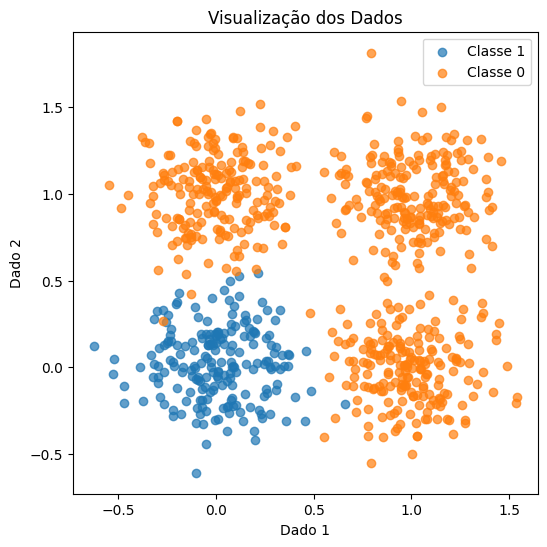

In [40]:
plt.figure(figsize=(6, 6))
for label in data_holdout["Y desejado"].unique():
    subset = data_holdout[data_holdout["Y desejado"] == label]
    plt.scatter(subset["Dado 1"], subset["Dado 2"], label=f"Classe {int(label)}", alpha=0.7)

plt.title("Visualização dos Dados")
plt.xlabel("Dado 1")
plt.ylabel("Dado 2")
plt.legend()
plt.grid(False)
plt.show()

# Divisão Holdout

In [41]:
X = data_holdout[["Dado 1", "Dado 2"]].values
y = data_holdout["Y desejado"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3, stratify=y)

# Chamada do Neurônio Perceptron

In [42]:
np.random.seed(3)
perceptron = Perceptron(n_inputs=X.shape[1], taxa_aprendizado=0.01)
perceptron.train(X_train, y_train, intervalo_pesos=(-0.5, 0.5))

# Avaliação e Métricas

+-----------------------------+
|   Comparação das Métricas   |
+-----------+--------+--------+
| Métrica   | Treino | Teste  |
+-----------+--------+--------+
| Acurácia  | 0.9607 | 0.9583 |
| Precisão  | 0.8782 | 0.9032 |
| Revocação | 0.9786 | 0.9333 |
| F1-Score  | 0.9257 | 0.9180 |
+-----------+--------+--------+



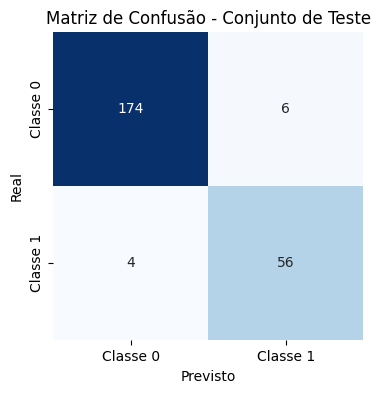

In [43]:
# Previsões
y_pred_train = np.array([perceptron.previsao(x) for x in X_train])
y_pred_test = np.array([perceptron.previsao(x) for x in X_test])

# Métricas - Treino
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, zero_division=0)
recall_train = recall_score(y_train, y_pred_train, zero_division=0)
f1_train = f1_score(y_train, y_pred_train, zero_division=0)

# Métricas - Teste
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test, zero_division=0)
recall_test = recall_score(y_test, y_pred_test, zero_division=0)
f1_test = f1_score(y_test, y_pred_test, zero_division=0)

# Criar tabela com PrettyTable
table = PrettyTable()
table.title = "Comparação das Métricas"
table.field_names = ["Métrica", "Treino", "Teste"]
table.align["Métrica"] = "l"

# Adicionar linhas com os valores reais
table.add_row(["Acurácia", f"{accuracy_train:.4f}", f"{accuracy_test:.4f}"])
table.add_row(["Precisão", f"{precision_train:.4f}", f"{precision_test:.4f}"])
table.add_row(["Revocação", f"{recall_train:.4f}", f"{recall_test:.4f}"])
table.add_row(["F1-Score", f"{f1_train:.4f}", f"{f1_test:.4f}"])

# Exibir tabela
print(table)
print()

# Exibir matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Classe 0", "Classe 1"], yticklabels=["Classe 0", "Classe 1"])
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Conjunto de Teste")
plt.show()

### Análise da Qualidade da Solução com Base nas Métricas do Conjunto de Testes

A avaliação do modelo Perceptron sobre o conjunto de testes forneceu os seguintes resultados:

- **Acurácia:** 0.9583  
- **Precisão:** 0.9032  
- **Revocação (Recall):** 0.9333  
- **F1-Score:** 0.9180  

---

#### Discussão Crítica

Os resultados obtidos demonstram que o Perceptron teve um desempenho bastante satisfatório na tarefa de classificação. A acurácia de aproximadamente 95,8% indica uma taxa global de acertos elevada, enquanto as métricas de precisão e revocação mostram que o modelo possui um bom equilíbrio entre a capacidade de evitar falsos positivos e identificar corretamente os exemplos positivos.

A **precisão** de 90,32% sugere que, entre todas as previsões positivas feitas pelo modelo, a maioria foi de fato correta. Já a **revocação** de 93,33% indica que o Perceptron conseguiu identificar a maior parte das amostras pertencentes à classe positiva. O **F1-Score** de 91,80%, por sua vez, confirma que o modelo mantém um bom equilíbrio entre essas duas medidas, sendo especialmente útil em cenários com distribuição de classes relativamente equilibrada.

---

#### Considerações Importantes

Apesar dos bons resultados, é importante observar que o modelo ainda cometeu alguns erros de classificação: 6 instâncias da classe 0 foram incorretamente classificadas como classe 1, e 4 da classe 1 foram classificadas como classe 0. Isso evidencia a limitação do Perceptron ao lidar com regiões que não são perfeitamente separáveis por uma fronteira linear.

Recomenda-se, portanto, como continuidade do trabalho:

- Avaliar o modelo com **validação cruzada (k-fold)**;
- Comparar com classificadores não lineares, como SVM com kernel, redes neurais multicamadas, ou árvore de decisão;
- Verificar a performance com diferentes taxas de aprendizado e épocas de treinamento.

---

#### Conclusão

> O Perceptron apresentou uma performance sólida no conjunto de testes, com métricas que evidenciam boa generalização. No entanto, os erros observados sugerem que, embora eficaz, o modelo pode se beneficiar de abordagens mais robustas para problemas não linearmente separáveis.

# Gráficos com fronteira de decisão

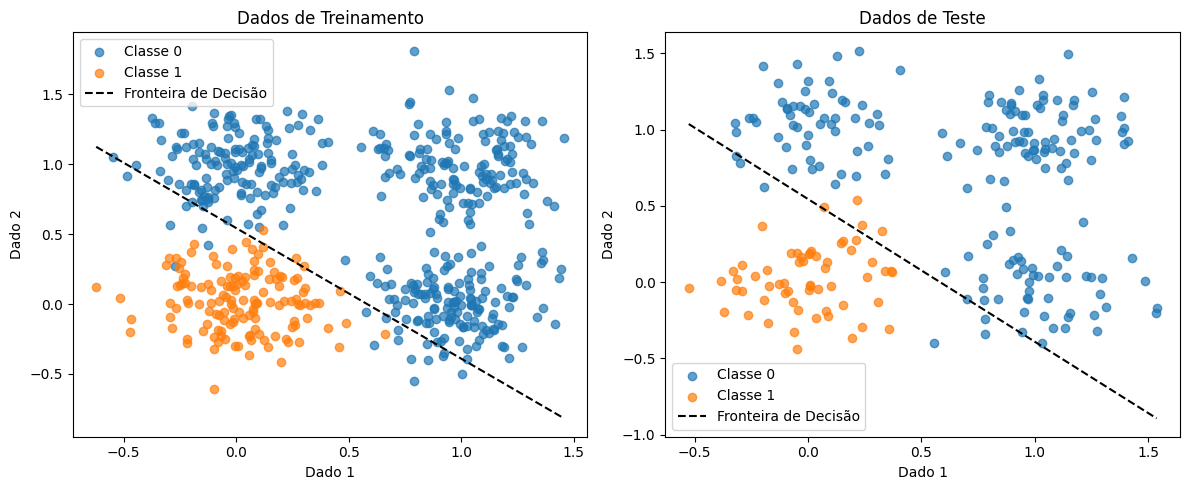

In [44]:
def plot_decision_boundaries_side_by_side(X_train, y_train, X_test, y_test, perceptron):
    """
    Plota a fronteira de decisão para os resultados de problemas não linearmente separáveis.

    Esta função cria uma visualização comparativa mostrando:
    - A distribuição de treinamento e teste
    - A fronteira de decisão aprendida pelo Perceptron
    - A separação entre as classes
    """

    # Configura os subplots lado a lado
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Dados a serem plotados
    datasets = [(X_train, y_train, "Dados de Treinamento"), (X_test, y_test, "Dados de Teste")]

    # Plota cada conjunto de dados em um subplot
    for ax, (X, y, title) in zip(axes, datasets):
        # Plot dos pontos de dados por classe
        for label in np.unique(y):
            subset = X[y == label]
            ax.scatter(subset[:, 0], subset[:, 1], label=f"Classe {int(label)}", alpha=0.7)

        # Cálculo e Plot da fronteira de decisão
        x_vals = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
        if perceptron.pesos[2] != 0:
            y_vals = -(perceptron.pesos[0] + perceptron.pesos[1]*x_vals) / perceptron.pesos[2]
            ax.plot(x_vals, y_vals, 'k--', label="Fronteira de Decisão")

        #Estilizando o gráfico
        ax.set_title(title)
        ax.set_xlabel("Dado 1")
        ax.set_ylabel("Dado 2")
        ax.grid(False)
        ax.legend()

    plt.tight_layout()
    plt.show()

# Chamar a função
plot_decision_boundaries_side_by_side(X_train, y_train, X_test, y_test, perceptron)